# PROJECT: Course Optimization for Data Science
## Optimization strategies for (Rank-)Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Robert Gower

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs for binary classification with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the "without intercept" case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- use these solvers to tackle the SVM-rank ML problem
- present a clear benchmark of the different strategies on small and medium scale datasets
- test your code on real data!


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 17th of January 2021 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "alexandre"
ln1 = "marquis"
fn2 = "antoine"
ln2 = "faul"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_marquis_alexandre_and_faul_antoine.ipynb


Some imports

In [ ]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install -c conda-forge cvxopt`

(if you're using conda)

or

`pip install cvxopt`

See https://cvxopt.org/install/ for instructions.

If you **struggle too much please contact us**. Don't waste time with this!

<div class="alert alert-info">
    <h2>Part 0: SVM Classification with linear kernel</h2>
</div>

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src='https://drive.google.com/uc?id=1n2O9hcwe7oajPIdNk6wvMVOzOpBFUvzN' />

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

We can rewrite $$(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2} \Vert w \Vert ^2
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.$$ $\Vert~.~\Vert^2  $ is a convex function.Moreover, the constraints are linear so they define convex sets and the intersections of those convex set is also a convex set. Optimizing a convex function over a convex set define a convex problem.

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:</li>
    </ul>

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

Remark: We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.
</div>

First $\mu \in \mathbb{R}_+^n \textrm{ so } -\mu \leq 0$ \\
Now let's write the Lagragian. \\
$$ \displaystyle \mathcal{L}(𝑤,𝑏,\mu) = \frac{1}{2} \Vert w \Vert ^2 + \sum_{i = 1}^n \mu_i (1 - y_i(w^tx_i + b)) = \frac{1}{2} \Vert w \Vert ^2 - \sum_{i = 1}^n \mu_i y_iw^tx_i + \sum_{i = 1}^n \mu_i - \sum_{i = 1}^n \mu_iy_ib$$
By taking the derivative of the Lagrangian we obtain two equations : 
$$
0 = w - \sum_{i=1}^n \mu_i y_i x_i\\
0 = \sum_{i=1}^n \mu_i y_i  \hphantom{10} (y^T\mu=0)$$

We see that $$w = \sum_{i=1}^n \mu_i y_i x_i$$ and we plug it in the Lagrangian (we also remove the $b$ term thanks to $y^T\mu=0$). \\
$$\displaystyle \mathcal{L}(𝑤,𝑏,\mu) = \frac{1}{2} (\sum_{i=1}^n \mu_i y_i x_i)^T(\sum_{i=1}^n \mu_i y_i x_i) - \sum_{i = 1}^n \mu_i y_i (\sum_{j=1}^n \mu_j y_j x_j)^Tx_i )+ \sum_{i = 1}^n \mu_i = - \frac{1}{2} \mu^T GG^T \mu + \mu^T u $$ 

For the dual problem we find the sup of $\mathcal{L}$, so the inf of - $\mathcal{L}$. Thus we find the dual problem.


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:</li>
    </ul>
    $$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$
</div>

$$ \sum_{i=1}^{n} \mu_i y_i x_i^\top x + b = 0$$ is the equation of the hyperplan computed thanks to the training samples. The plan devide the space in two, so y will be the sign depending on wich side of the space it is in. Thus $$y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b)$$ 
By replacing in the affine function $f(x)=\mathrm{sign}(w^{\top}x + b)$ we obtain   $\displaystyle w = \sum_{i=1}^{n} \mu_i y_i x_i$.

<div class="alert alert-info">
    <h2>Part 1: Implementation of solver with intercept using cvxopt</h2>
</div>

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [ ]:
from svm_project_utils import plot_dataset, datasets

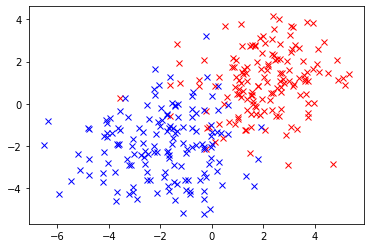

In [ ]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [ ]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [ ]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
       <li>Modify the following cell to solve the SVM dual problem:</li>
    </ul>
</div>

Number of support vectors: 3


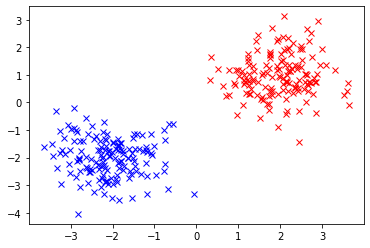

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)
# TODO
def svm_solver(K, y, C=np.inf):
    H = K * np.outer(y, y)
    e = cvxopt.matrix(np.ones((len(y), 1)), tc='d')
    A = cvxopt.matrix(y.reshape((1,-1)), tc='d')
    b = cvxopt.matrix([0.0])

    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
       <li>Compute w from mu and b</li>
    </ul>
</div>

In [ ]:
# TODO
w = np.sum((mu_support * y[idx_support]).reshape(-1,1) * X[idx_support], axis=0)
print(w)

[1.17129691 0.60681477]


<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
       <li>Using complementary slackness, explain how to obtain $b$ from $\mu$.</li>
    </ul>
<br/>
    <b>Remark:</b> complementary slackness states that if $\mu_i$ is an optimal lagrange multiplier and $f_i$ is a constraint of the primal problem than $\mu_i f_i(x^*) = 0$, where x^* is here a primal optimal value (notations here do not match the SVM context).
<br/><br/>
    <b>HINT:</b> Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.
<br/><br/>
    <b>HINT:</b> Have a look at <a href="https://web.stanford.edu/class/ee364a/lectures/duality.pdf">these slides</a> and chapter 5 in <a href="https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf"> this book </a> for more information on convex duality.
</div>

The complementary slackness condition is : 
$$\forall i \in \{1,\cdots,n\} , \mu_i (1 - y_i(w^{*^T}x_i + b)) = 0$$
So if we take $i$ such that $\mu_i \neq 0$ we have :
$$y_i(w^{*^T}x_i + b)) = 1$$
$$w^{*^T}x_i + b = \frac{1}{y_i} = y_i$$
So :
$$b = y_i - (w^{*^T}x_i)$$

We take the average for a more robuste estimation.

In [52]:
from sklearn.linear_model import LassoCV
def compute_b(K, y, mu_support, idx_support):
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    b = np.mean(y_support - mu_support * y_support @ K_support)
    return b

b = compute_b(K, y, mu_support, idx_support)

0.14713973510502473

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
       <li>Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:</li>
    </ul>
$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.
</div>

In [ ]:
# TODO
e = 1e-5
def check_ineq_const(X, y, w, b, e):
  g = np.empty(len(y))
  for i in range(len(y)):
    g[i] = y[i] * (w.T @ X[i] + b)
  print('Number of constraint violated : ', len(g[g < 1 - e]))
check_ineq_const(X, y, w, b, e)

Number of constraint violated :  3


Check your code by running the following cell:

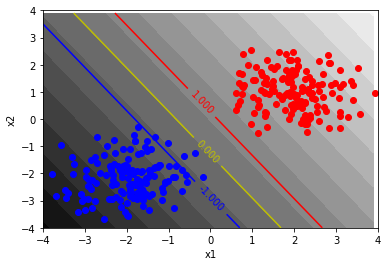

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], colors=['b', 'y', 'r'])
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearly separable anymore.

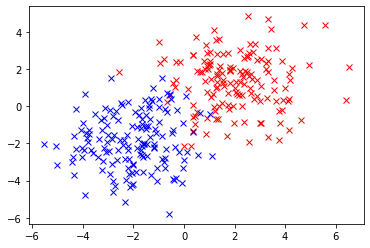

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [ ]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
       <li>Check that constraints of the problem are now violated, can you explain what happened? How many are there according to the precision given in Question 7?</li>
    </ul>
</div>

Now that the problem is not linearly separable there a some points that will be on the "wrong" side of the space, so the constraint involving them will be violated.

In [ ]:
e = 1e-5
check_ineq_const(X, y, w, b, e) #TODO

Number of constraint violated :  300


In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
         <li>Justify that $(P_{s})$ is a convex problem.</li>
         <li>Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div>

We are still working with $\Vert~.~\Vert^2 $ which is a convex function, and the constraints are still linear so the problem stay convex. \\
The New Lagrangian is : 

$$
\begin{array}{lll}
\ \mathcal{L}(𝑤,𝑏,\mu, \beta) &= \frac{1}{2} \Vert w \Vert ^2 + C \sum_{i = 1}^n \xi_i +\sum_{i = 1}^n \mu_i (1- \xi_i - y_i(w^tx_i + b)) - \sum_{i = 1}^n \beta_i \xi_i \\
& = \frac{1}{2} \Vert w \Vert ^2 + C \sum_{i = 1}^n \xi_i - \sum_{i = 1}^n \mu_i y_iw^tx_i + \sum_{i = 1}^n \mu_i - \sum_{i = 1}^n \mu_iy_ib - \sum_{i = 1}^n \mu_i \xi_i - \sum_{i = 1}^n \beta_i \xi_i
\
\end{array}
$$ 
We have a new equation when taking the derivative with respect to $\xi$ :
$$
0 = -\mu - \beta + C
$$
$\beta$ being in $\mathbb{R}_+^n$ we have the new part of the problem : $\mu \leq C$ and the term $\sum_{i = 1}^n (C - \mu_i - \beta_i) \xi_i$ disapear in the Lagragian so the rest of the problem stay the same.

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
       <li>Modify your code from Question 4 to handle the non-separable case.</li>
    </ul>
</div>

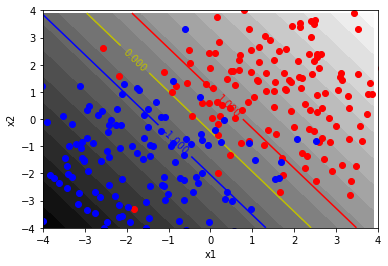

In [ ]:
# TODO

X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
       <li>What is the influence of C on the number of support vectors? Make a plot that demonstrates this empirically.</li>
    </ul>
</div>

C tell how much we want to avoid doing a misclassification so when C is larger, there will be globally more support vectors.

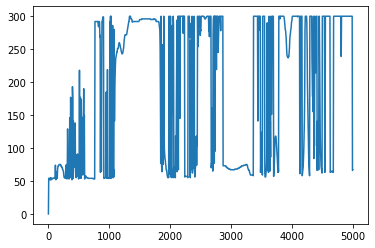

In [ ]:
Cs = np.linspace(0,5000,1001)
n_supp_vect = []
for C in Cs :
  mu_support, idx_support = svm_solver(K, y, C=C)
  n_supp_vect.append(len(mu_support))

plt.plot(Cs, n_supp_vect)

<div class="alert alert-info">
    <h2>Part 3: non-linear case with kernels</h2>
</div>

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
     <ul>
       <li>Denoting by $K(x_i, x_j)$ the dot product between samples, show that dual problem and the decision function f(x) can be reformulated just using calls to $K$</li>
    </ul>
</div> 

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i k(x_i, x) + b)
$$
And
$$\displaystyle \mathcal{L}(𝑤,𝑏,\mu) =- \frac{1}{2} \sum_{i = 1}^n \mu_i y_i (\sum_{j=1}^n \mu_j y_j x_j)^Tx_i )+ \sum_{i = 1}^n \mu_i = \sum_{i = 1}^n \sum_{j=1}^n\mu_i y_i  \mu_j y_j k(x_j,x_i)+ \sum_{i = 1}^n \mu_i$$ 

We will use the clowns dataset to evaluate this:

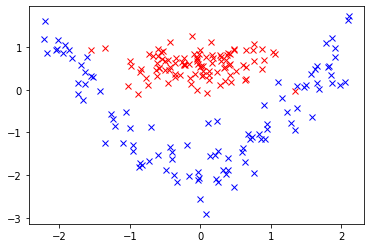

In [ ]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

<div class="alert alert-success">
    <b>QUESTION 13:</b>
     <ul>
       <li>Update your kernel function so it computes the Gaussian kernel:</li>
    </ul>
    $$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
$$

where $\gamma > 0$ is the kernel bandwidth.
</div> 

In [ ]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    # TO DO
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma * linalg.norm(X1[i] - X2[j])**2 )
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

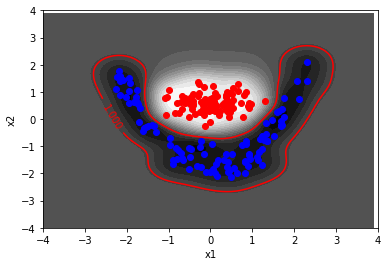

In [ ]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)
plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

<div class="alert alert-info">
    <h2>Part 4: Linear SVM without intercept</h2>
</div>

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^\top \mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 14:</b>
     <ul>
       <li>Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div> 

It's the same problem as earlier, but since we don't have $b$, when we take the derivative there is no equation $0 = \sum_{i=1}^n \mu_i y_i$  so the constraint $y^\top \mu = 0$ disappear. 

<div class="alert alert-success">
    <b>QUESTION 15:</b>
     <ul>
       <li>Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$
         </li>
    </ul>
</div>

We can rewrite the problem as :
$$\displaystyle(\mathcal{D}): \min_{\mu} \frac{1}{2}\Vert G^T\mu \Vert^2 +  \sum_{i = 1}^n \mathbb{1}_{[0, C]}(\mu_i) - \mu_i $$
We use the indicator for the constraint.

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 16:</b>
     Implement:
     <ul>
       <li>your own version of proximal gradient with and without acceleration</li>
       <li>your own version of coordinate descent</li>
       <li>an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
    Test your implementations on the Gaussian blobs and evaluate the performance
    of your implementations in terms of computation time on problems where the matrix 
    $G G^\top$ can fit in memory. Give a short conclusion.
</div>

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is voluntary vague, but it is the most important and will constitute half of the final grade on the project ! We are waiting for beautiful plots, as well as sharp comments!**

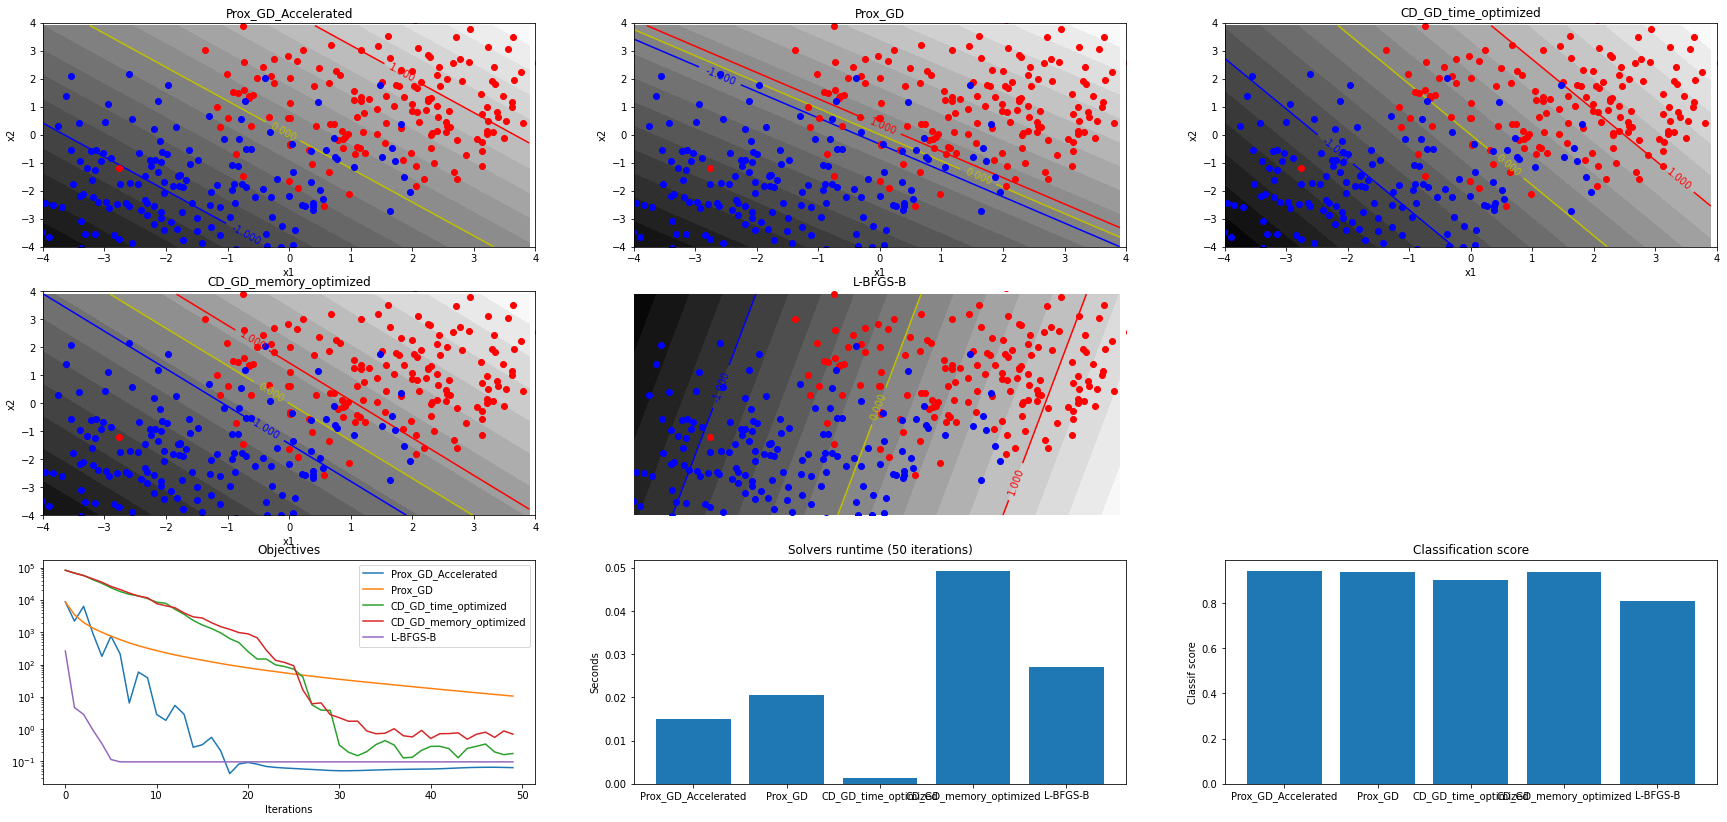

In [ ]:
# TODO
from scipy.optimize import fmin_l_bfgs_b
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from numba import njit

X, y = datasets(name='gaussian', n_points=500, sigma=1.7)
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
X, X_test, y, y_test = train_test_split(X, y)
G = np.array([y[i] * X[i].T for i in range(len(y))])
mu0 = np.random.rand(len(y))
lips_const = np.linalg.norm(G.T, axis=0)**2

@njit
def f(x, G):
  for i in range(len(x)):
    if 0 > x[i] or x[i] > C:
      return np.inf
  return (1/2) * np.linalg.norm(G.T @ x)**2

@njit
def grad_f(x, G):
  return G @ G.T @ x - 1


@njit
def prox_g_i(x, C):
  if x > C:
    return C
  elif x < 0:
    return 0.
  return x

@njit
def prox_g(x, C):
  for i in range(len(x)):
      x[i] = prox_g_i(x[i], C)
  return x

@njit
def prox_gd(mu0, f, grad_f, prox_g, G, C= 1.0, n_iter=50, accelerated = True):
  step = np.linalg.norm(G.T, ord=2)**2
  mu = mu0.copy()
  objectives = [] # contain mu at each step

  if accelerated:
    z = mu.copy()
    t = 1
  for k in range(n_iter):
    if accelerated :
      mu_new = prox_g(z - grad_f(z, G)/step, C)
      t_new  = (1 + np.sqrt(1 + 4 * t**2))/2
      z      = mu_new + ((t - 1)/t_new) * mu_new - mu
      t      = t_new
      mu     = mu_new
    else :
      mu = prox_g(mu - grad_f(mu, G)/step, C)

    objectives.append(f(mu, G))
  return mu, objectives

@njit
def cd_gd(mu0, f, grad_f, prox_g_i, G, lips_const, C = 1.0, n_iter = 50, opti='mem'): #fair tests
    mu_size = mu0.shape[0]
    mu = mu0.copy()
    objectives = []
    if opti == 'time':
      GG = G @ G.T
    for t in range(n_iter):
        for j in np.random.randint(0, mu_size, min(200,int(mu_size/10))): #range(mu_size):
            if opti == 'time':
              U = GG[j] @ mu - 1
              if U != 0:
                mu[j] = prox_g_i(mu[j] - U/(lips_const[j]+(t/4)), C)
            else:
              test = np.array([G[j] @ G.T[:,i] for i in range(len(mu))])
              U = test @ mu - 1
              if U != 0:
                mu[j] = prox_g_i(mu[j] - U/lips_const[j], C)
        objectives.append(f(mu, G))
    return mu,objectives

def l_bfgs_b_solver(mu0, f, grad_f, G, C = 1, n_iter=50): #pas terrible
  bounds = np.repeat([[0,1]], len(mu0), axis=0)
  objectives = []
  callback = lambda x : objectives.append(f(x, G))
  mu = fmin_l_bfgs_b(f, mu0, grad_f, args=(G,), maxiter=n_iter, bounds=bounds, callback=callback)[0]
  objectives += [f(mu, G)]*(n_iter - len(objectives))
  return mu, objectives


solvers_names = ["Prox_GD_Accelerated", "Prox_GD", "CD_GD_time_optimized", "CD_GD_memory_optimized" ,  "L-BFGS-B"]
solvers = [
  (prox_gd, (mu0, f, grad_f, prox_g, G)),
  (prox_gd, (mu0, f, grad_f, prox_g, G, 1.0, 50, False)),
  (cd_gd, (mu0, f, grad_f, prox_g_i, G, lips_const, 1.0, 50, 'time')),
  (cd_gd, (mu0, f, grad_f, prox_g_i, G, lips_const, 1.0, 50, 'mem')),
  (l_bfgs_b_solver, (mu0, f, grad_f, G)),
]
objectives_solvers =  []
classif_solvers =  []
times_solvers = []
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(30, 14))

for solver, args in solvers: # we call solver one time to precompile them, there may be other ways to do that but I didn't find
  solver(*args)

for i, (solver, args) in enumerate(solvers):
  start = timer()
  mu, objectives = solver(*args) 
  idx_support = np.where(np.abs(mu) > 1e-5)[0]
  mu_support = mu[idx_support]

  times_solvers.append((timer() - start))
  objectives_solvers.append(objectives)
  
  plt.axes(eval('ax'+str(i + 1)))
  plt.title(solvers_names[i])
  plot_classif(X[:,0:2], y, mu_support, idx_support, 0)


  #test our solution
  X_support = X[idx_support]
  K = kernel(X_test, X_support)
  decision = K.dot(mu_support * y[idx_support])
  y_pred = np.sign(decision)
  classif = np.sum([1 if y_pred[i] == y_test[i] else 0 for i in range(len(y_pred))])/len(y_pred)
  classif_solvers.append(classif)


ax5.axis('off')
ax6.axis('off')
plt.axes(ax7)

for objective in objectives_solvers:
  plt.plot(range(50), objective)
plt.legend(solvers_names)
plt.yscale('log')
plt.title("Objectives")
plt.xlabel('Iterations')
plt.axes(ax8)
plt.bar(solvers_names, times_solvers)
plt.title("Solvers runtime (50 iterations)")
plt.ylabel('Seconds')

plt.axes(ax9)
plt.bar(solvers_names, classif_solvers)
plt.title("Classification score")
plt.ylabel('Classif score')
plt.show()


By looking at those plot, we can say that the proximal gradient descent accelerated is the best solution : it converge quickly and take significatively less time than the other solutions.

<div class="alert alert-info">
    <h2>Part 5: SVM Rank</h2>
</div>

You will now use the code you have written above to answer the following question: given two samples $x_i$ and $x_j$ in $\mathbb{R}^p$, with corresping labels $y_i$ and $y_j$ in $\mathbb{R}$ (note that now labels can be any real number, it's not just binary). Can I predict if $y_i > y_j$ or the oppositve?

To take a concrete example, imaging you go to a liquor store to buy a bottle on wine and you hesitate between two bottles. The SVM Rank model below will tell you if the quality of the wine encoded in the target $y$ is better for the first bottle or the second one.

Let's formalize this a bit. We aim to estimate a linear function $f_{w}(x) = x^\top w$ that minimizes
the following risk:

$$
\mathcal{R}_f=\mathbb{E}
    \left[
    \ell(f_w(x_i) - f_w(x_j), \mathrm{sign}(y_i-y_j))
    \right]
$$

where the loss $\ell$ is the Hinge loss of the SVM binary classifical model you have seen above. Namely:
$
    \ell(z, t) = \max(1 - tz, 0)
$ . Note that we limit ourselves here to linear SVM.

This leads to the following regularized empirical risk minimization problem:

$$
\hat{w} = \mathrm{arg}\,\min_{w \in \mathbb{R}^p} \left( C \sum_{i,j} \ell((x_i - x_j)^\top w, \mathrm{sign}(y_i-y_j)) + \|w\|_2^2 \right),
$$


This part is inspired by the following works:

    - R. Herbrich, T. Graepel, and K. Obermayer. Large margin rank boundaries for ordinal regression. MIT Press, Cambridge, MA, 2000.

    - T. Joachims. Optimizing search engines using clickthrough data. In Proceedings of the eighth ACM SIGKDD international conference on Knowledge discovery and data mining, pages 133–142, New York, NY, USA, 2002. ACM. 2
    
The following cell implements the `transform_pairwise` function. Given `X` and `y` this function builds all the pairs of samples to output a new dataset that corresponds to a binary classification problem. It basically outputs the differences between feature vectors and the sign of the difference of the targets.

In [ ]:
import itertools


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking

    Transforms a n-class ranking problem into a two-class classification
    problem.

    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        Target labels.

    Returns
    -------
    X_trans : array, shape (n_pairs, n_features)
        Data formed by difference of feature vectors.
    y_trans : array, shape (n_pairs,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    comb = itertools.combinations(range(X.shape[0]), 2)
    k = 0
    for (i, j) in comb:
        if y[i] == y[j]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i] - y[j]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
        k += 1
    return np.array(X_new), np.array(y_new)

<div class="alert alert-success">
    <b>QUESTION 17:</b>
     The following cell implements a scikit-learn estimator for the SVM Rank
     model. It uses the liblinear solver shipped with scikit-learn.
     <ul>
       <li>Update the following code to use a solver developed above instead of scikit-learn LinearSVC estimator.
         You will justify this choice of solver in terms of performance
         based your experiments above.</li>
       <li>Run your updated estimator on the Wine quality dataset
         and compare the performance of your model with the liblinear
         solver. You will compare in terms of prediction score
         and in terms of computation time.</li>
    </ul>
</div>

**Note:** For the scorer we use here the [Kendall's rank correlation](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

$$
    \tau ={\frac {2}{n(n-1)}}\sum _{i<j}\operatorname {sgn}(x_{i}-x_{j})\operatorname {sgn}(y_{i}-y_{j})
$$

implemented in `scipy.stats.kendalltau`.

In [ ]:
from scipy import stats
from sklearn import svm
from sklearn.base import BaseEstimator, RegressorMixin


class RankSVM(BaseEstimator, RegressorMixin):
    """Performs pairwise ranking with an underlying linear SVM model

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    """
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        """Fit a pairwise ranking model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        self
        """
        X_trans, y_trans = transform_pairwise(X, y)
        G = np.array([y_trans[i] * X_trans[i].T for i in range(len(y_trans))])
        lips_const = np.linalg.norm(G.T, axis=0)**2
        mu0 = np.random.rand(len(y_trans))
        mu, objs= cd_gd(mu0, f, grad_f, prox_g_i, G, lips_const, C = 1.0, n_iter = 50, opti='mem')
        idx_support = np.where(np.abs(mu) > 1e-5)[0]
        mu_support = mu[idx_support]
        w = np.sum((mu_support * y_trans[idx_support])[: , None] * X_trans[idx_support], axis=0)
        self.w = w
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        ord : array, shape (n_samples,)
            Returns an array of integers representing the relative order of
            the rows in X.
        """
        return np.argsort(np.dot(X, self.w.T).ravel())  #self.svc_.coef_.T

    def score(self, X, y):
        """Score using Kendall rank correlation
        
        https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        score : float
            Kendall Tau rank correlation. Higher is better.
        """
        return stats.kendalltau(self.predict(X), y)[0]

In [ ]:
# Loading the data
import pandas as pd
from sklearn.model_selection import cross_val_score

df = pd.read_csv('winequality-red.csv', delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import gc
gc.collect()
df_small = df[::2]  # take a smaller dataset to speed things up
X = df_small.iloc[:, :-1].values

y = df_small.quality.values
clf = make_pipeline(StandardScaler(), RankSVM(C=1.))

scores = cross_val_score(clf, X, y, cv=3)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())

Average Kendall Rank Correlation: 0.09
CPU times: user 4min 13s, sys: 3min, total: 7min 14s
Wall time: 3min 41s


We choose the Coordinate Gradient descent because it is the best solution if we do not have enought space to store th $GG^T$ matrix. The result score is nearly the same than with the LinearSVC estimator but we take way more time (around 3 minutes). 